# Business Question

The New York Times is reevaluating the comment moderation on its web content, in hopes of stimulating reader engagement, deepening the quality of user feedback, and identifying potentially problematic comments more quickly. They would like to use the existing recommendation tool to develop a machine learning model that will predict which comments will be most popular and which comments will be most likely to generate further engagement. The end goal will be to sort comments according to this prediction (as a third option available to users in addition to presenting comments ranked in response to recommendations or chronologically). Additionally, they would like to identify comments that are most likely to be flagged as abuse to bring these comments to the attention of moderators more quickly. 

### Data Acquisition
The data used for this project represents articles and comments on The New York Times website in April 2017. I downloaded the dataset from Kaggle [at this address](https://www.kaggle.com/aashita/nyt-comments). The data was originally collected using the New York Times API. The process for this collection is well-documented on the Kaggle page. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

import gc

#hate speech library
!pip install hatesonar
from hatesonar import Sonar

#toggle variable to print previews, 'sanity checks'
print_detail = True

## Preprocessing

In [3]:
# DELETE ME if you end up wanting to expand and add more data to the dataset, you can combine the datasets before this cell 
# and name them art/comm and then pick up at this point.

# article_paths = ['data/ArticlesApril2017.csv',
#                  'data/ArticlesApril2018.csv',
#                  'data/ArticlesJan2017.csv',
#                  'data/ArticlesJan2018.csv']

# comment_paths = ['data/CommentsApril2017.csv',
#                  'data/CommentsApril2018.csv',
#                  'data/CommentsJan2017.csv',
#                  'data/CommentsJan2018.csv']

# prefix = 'gdrive/MyDrive/'

# # read in datasets of articles
# art = pd.read_csv(prefix + article_paths[0])
# for each in article_paths[1:]:
#     print('appending ' + each)
#     temp = pd.read_csv(prefix + each)
#     art = pd.concat([art, temp])
#     print('df shape ' + str(art.shape))
        
# # read in dataset of comments
# comm = pd.read_csv(prefix + comment_paths[0])
# for each in comment_paths[1:]:
#     print('appending ' + each)
#     temp = pd.read_csv(prefix + each)
#     comm = pd.concat([comm, temp])
#     print('df shape ' + str(comm.shape))


art = pd.read_csv('gdrive/MyDrive/data/ArticlesApril2018.csv')

comm = pd.read_csv('gdrive/MyDrive/data/CommentsApril2018.csv')
    
if print_detail:
    # preview
    display(art.info())
    display(comm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   articleID         1324 non-null   object
 1   articleWordCount  1324 non-null   int64 
 2   byline            1324 non-null   object
 3   documentType      1324 non-null   object
 4   headline          1324 non-null   object
 5   keywords          1324 non-null   object
 6   multimedia        1324 non-null   int64 
 7   newDesk           1324 non-null   object
 8   printPage         1324 non-null   int64 
 9   pubDate           1324 non-null   object
 10  sectionName       1324 non-null   object
 11  snippet           1324 non-null   object
 12  source            1324 non-null   object
 13  typeOfMaterial    1324 non-null   object
 14  webURL            1324 non-null   object
dtypes: int64(3), object(12)
memory usage: 155.3+ KB


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.



None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   approveDate            264924 non-null  int64  
 1   articleID              264924 non-null  object 
 2   articleWordCount       264924 non-null  float64
 3   commentBody            264924 non-null  object 
 4   commentID              264924 non-null  float64
 5   commentSequence        264924 non-null  float64
 6   commentTitle           264911 non-null  object 
 7   commentType            264924 non-null  object 
 8   createDate             264924 non-null  int64  
 9   depth                  264924 non-null  float64
 10  editorsSelection       264924 non-null  bool   
 11  inReplyTo              264924 non-null  float64
 12  newDesk                264924 non-null  object 
 13  parentID               264924 non-null  float64
 14  parentUserDisplayName  83875 non-nul

None

In [4]:
if print_detail:
    #preview
    display(art.head())
    display(comm.head())

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1524594282,5adf6684068401528a2aa69b,781.0,How could the league possibly refuse this offe...,26853969.0,26853969.0,<br/>,comment,1524594011,1.0,False,0.0,Sports,0.0,NaN,26853969,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594282,Christopher Rillo,46566740.0,San Francisco,NaN,NaN
1,1524594252,5adf6684068401528a2aa69b,781.0,"So then the execs can be like ""yeah...we will ...",26853699.0,26853699.0,<br/>,comment,1524593146,1.0,False,0.0,Sports,0.0,NaN,26853699,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594252,Matt Brand,64324866.0,"Williamsburg, Brooklyn",NaN,NaN
2,1524594250,5adf6684068401528a2aa69b,781.0,I would not want to play chess against these c...,26853677.0,26853677.0,<br/>,comment,1524593032,1.0,False,0.0,Sports,0.0,NaN,26853677,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594250,Joseph,78105093.0,"Fayetteville, AR",NaN,NaN
3,1524593431,5adf6684068401528a2aa69b,781.0,Could the cheerleaders join the Actors' Equity...,26853784.0,26853784.0,<br/>,comment,1524593426,1.0,False,0.0,Sports,0.0,NaN,26853784,http://graphics8.nytimes.com/images/apps/times...,0.0,3,NaN,0,NaN,Pro Football,0,approved,0,0,News,1524593431,Stephen,81939618.0,"Phoenix, AZ",NaN,NaN
4,1524595048,5adf653f068401528a2aa697,656.0,Seeking conclusions which support preconceived...,26854236.0,26854236.0,<br/>,comment,1524595043,1.0,False,0.0,Climate,0.0,NaN,26854236,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Unknown,1,approved,1,0,News,1524595048,Paul Zorsky,58642997.0,Texas,NaN,NaN


In [5]:
print('Article columns: ')
display(art.columns)
print('Comments columns: ')
display(comm.columns)

Article columns: 


Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')

Comments columns: 


Index(['approveDate', 'articleID', 'articleWordCount', 'commentBody',
       'commentID', 'commentSequence', 'commentTitle', 'commentType',
       'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk',
       'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage',
       'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag',
       'sectionName', 'sharing', 'status', 'timespeople', 'trusted',
       'typeOfMaterial', 'updateDate', 'userDisplayName', 'userID',
       'userLocation', 'userTitle', 'userURL'],
      dtype='object')

In [6]:
#combine the article and comment dataframes using articleID as an index
df = pd.merge(comm, art, on='articleID')

if print_detail:
    df.head()



In [7]:
del comm
del art
gc.collect()

54

In [8]:
df.columns

Index(['approveDate', 'articleID', 'articleWordCount_x', 'commentBody',
       'commentID', 'commentSequence', 'commentTitle', 'commentType',
       'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk_x',
       'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage_x',
       'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag',
       'sectionName_x', 'sharing', 'status', 'timespeople', 'trusted',
       'typeOfMaterial_x', 'updateDate', 'userDisplayName', 'userID',
       'userLocation', 'userTitle', 'userURL', 'articleWordCount_y', 'byline',
       'documentType', 'headline', 'keywords', 'multimedia', 'newDesk_y',
       'printPage_y', 'pubDate', 'sectionName_y', 'snippet', 'source',
       'typeOfMaterial_y', 'webURL'],
      dtype='object')

Before I start the Exploratory Data Analysis (EDA), I want to eliminate some of the columns that are duplicates, or contain information that I know won't be helpful (such as URLs). Some of these columns I'm still unsure about. 

In [9]:
def reverse_drop(df, keep_list):
    '''pass in a dataframe and a list of the columns to keep. Will ID all columns NOT in list
    and drop them, returning the resulting dataframe'''
    
    
    to_drop = [item for item in list(df.columns) if item not in keep_list]

    # if print_detail:
    #     print(to_drop)

    return df.drop(columns=to_drop)


In [10]:
keep = ['commentBody', 'commentID', 'commentType', 
        'editorsSelection','recommendations', 'replyCount', 'articleID',
        'timespeople', 'trusted','sectionName_x', 'depth', 'inReplyTo',
        'newDesk_x', 'articleWordCount_x', 'typeOfMaterial_x' , 'pubDate',
        'documentType', 'headline']

df = reverse_drop(df, keep)

if print_detail:
    print(df.columns)

Index(['articleID', 'articleWordCount_x', 'commentBody', 'commentID',
       'commentType', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk_x',
       'recommendations', 'replyCount', 'sectionName_x', 'timespeople',
       'trusted', 'typeOfMaterial_x', 'documentType', 'headline', 'pubDate'],
      dtype='object')


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257661 entries, 0 to 257660
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   articleID           257661 non-null  object 
 1   articleWordCount_x  257661 non-null  float64
 2   commentBody         257661 non-null  object 
 3   commentID           257661 non-null  float64
 4   commentType         257661 non-null  object 
 5   depth               257661 non-null  float64
 6   editorsSelection    257661 non-null  bool   
 7   inReplyTo           257661 non-null  float64
 8   newDesk_x           257661 non-null  object 
 9   recommendations     257661 non-null  int64  
 10  replyCount          257661 non-null  int64  
 11  sectionName_x       257661 non-null  object 
 12  timespeople         257661 non-null  int64  
 13  trusted             257661 non-null  int64  
 14  typeOfMaterial_x    257661 non-null  object 
 15  documentType        257661 non-nul

## EDA part 1

### Initial Article Analysis/Feature Engineering

In [12]:
def quick_look(frame, col, range = None, bins = 10):
    '''displays the name, describe(), and histogram for the
        specified column'''
    print(col + ' description: ')
    display(frame[col].describe())
    display(frame[col].value_counts())
    
    if frame[col].nunique == 2:
        print('Boolean variable; no histogram created')
    
    else:
    
        plt.hist(frame[col],
                      range = range,
                      bins = bins)

        plt.title(col + ' Histogram')
        plt.show()

how many articles

In [13]:
print('Number of Articles: ')
print(df['articleID'].nunique())

Number of Articles: 
1324


section breakdown

One of the more interesting and useful ways that the data segments itself is by section. There are several variables (sectionName, newDesk, typeOfMaterial) that might end up being best for sorting the data, so I want to take a look at each of them to see which one is most helpful.

In [14]:
# the saddest little helper function
def print_categories(column):
    '''the function will print the name of a given column as well as all of the categories in that column'''
    print(column)
    display(df[column].unique())

#create a list of potential section variables
potential_ys = ['sectionName_x', 'newDesk_x', 'typeOfMaterial_x']

# print categories for each of the potential section variables
for each in potential_ys:
    print_categories(each)

sectionName_x


array(['Pro Football', 'Unknown', 'Europe', 'Canada', 'Politics',
       'Book Review', 'Eat', 'DealBook', 'Asia Pacific',
       'Wine, Beer & Cocktails', 'Family', 'Hockey', 'Africa',
       'Television', 'Economy', 'Middle East', 'Tennis', 'Sunday Review',
       'Live', 'The Daily', 'Move', 'Cycling', 'Americas', 'Australia',
       'Weddings', 'Art & Design', 'Lesson Plans', 'Personal Tech',
       'Music', 'Mind', 'Pro Basketball', 'Learning', 'Media', 'Golf',
       'College Basketball', 'Soccer'], dtype=object)

newDesk_x


array(['Sports', 'Climate', 'Dining', 'Washington', 'Foreign', 'NYTNow',
       'Express', 'Insider', 'Learning', 'Magazine', 'Metro',
       'RealEstate', 'Business', 'Politics', 'National',
       'SpecialSections', 'BookReview', 'Well', 'Games', 'Culture',
       'Editorial', 'OpEd', 'Arts&Leisure', 'Science', 'Travel', 'Upshot',
       'Metropolitan', 'Investigative', 'NewsDesk', 'Weekend',
       'SundayBusiness', 'Styles', 'Photo', 'Society', 'Obits',
       'Smarter Living', 'Podcasts', 'TStyle', 'Summary'], dtype=object)

typeOfMaterial_x


array(['News', 'briefing', 'Review', 'Editorial', 'Op-Ed',
       'News Analysis', 'Question', 'Obituary (Obit)'], dtype=object)

In [15]:
df_sections = df.groupby(by='newDesk_x').count()

display(df_sections['articleID'])
df_sections['commentBody'].sort_values(ascending=False)

newDesk_x
Arts&Leisure         497
BookReview          1036
Business           20697
Climate             3885
Culture             4803
Dining              1705
Editorial          10774
Express             2595
Foreign            14655
Games               3875
Insider              266
Investigative       4785
Learning            3436
Magazine            5552
Metro               5128
Metropolitan        1068
NYTNow                36
National           12293
NewsDesk            1429
Obits                826
OpEd               80574
Photo                124
Podcasts              14
Politics            7582
RealEstate          1580
Science             3517
Smarter Living        55
Society               99
SpecialSections      125
Sports              3240
Styles               631
Summary                6
SundayBusiness       422
TStyle                10
Travel               512
Upshot              1659
Washington         51576
Weekend              468
Well                6126
Name: articleID

newDesk_x
OpEd               80574
Washington         51576
Business           20697
Foreign            14655
National           12293
Editorial          10774
Politics            7582
Well                6126
Magazine            5552
Metro               5128
Culture             4803
Investigative       4785
Climate             3885
Games               3875
Science             3517
Learning            3436
Sports              3240
Express             2595
Dining              1705
Upshot              1659
RealEstate          1580
NewsDesk            1429
Metropolitan        1068
BookReview          1036
Obits                826
Styles               631
Travel               512
Arts&Leisure         497
Weekend              468
SundayBusiness       422
Insider              266
SpecialSections      125
Photo                124
Society               99
Smarter Living        55
NYTNow                36
Podcasts              14
TStyle                10
Summary                6
Name: commentBo

how many comments/article

commentID description: 


count    1324.000000
mean      194.608006
std       327.383266
min         1.000000
25%        16.000000
50%        67.000000
75%       215.000000
max      3823.000000
Name: commentID, dtype: float64

1       41
4       31
5       29
3       28
2       26
        ..
2245     1
196      1
483      1
486      1
2296     1
Name: commentID, Length: 467, dtype: int64

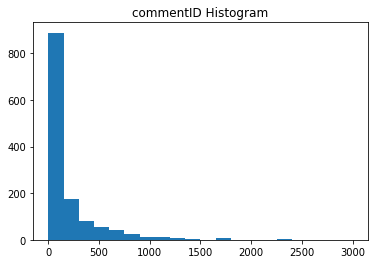

In [16]:
article_group = df.groupby(by='articleID').count()

quick_look(article_group, 'commentID', (0,3000), 20)


create a new column that lists the total number of comments for the article

In [17]:
df['article_comment_total'] = df['articleID'].apply(lambda x: article_group['commentID'][x])

In [18]:
article_sections =df.groupby(['newDesk_x']).mean()

article_sections['article_comment_total']

#quick_look(article_sections, 'commentID', (0,3000), 20)


newDesk_x
Arts&Leisure         45.241449
BookReview          567.117761
Business            942.381843
Climate             659.906564
Culture             447.141578
Dining              173.668622
Editorial           721.511045
Express             727.716763
Foreign             376.855067
Games               115.269935
Insider              94.669173
Investigative       764.772205
Learning            442.745052
Magazine            512.066643
Metro               278.060062
Metropolitan        203.882022
NYTNow               16.055556
National            430.648418
NewsDesk           1014.400980
Obits               421.820823
OpEd                692.985281
Photo                13.967742
Podcasts              2.142857
Politics            950.525719
RealEstate           79.224051
Science             411.371908
Smarter Living       53.036364
Society              99.000000
SpecialSections     119.144000
Sports              420.493827
Styles              239.896989
Summary               6.00000

In [19]:
#drop by section

# top_sections = ['OpEd', 
#                 'Business', 
#                 'NewsDesk', 
#                 'Washington', 
#                 'Foreign', 
#                 'National', 
#                 'Editorial']

# sections_to_drop = [item for item in list(df['newDesk_x'].unique()) if item not in top_sections]

# display(len(list(df['newDesk_x'].unique())))
# display(len(top_sections))
# display(len(sections_to_drop))


In [20]:
df['pubDate'] = pd.to_datetime(df['pubDate'])

df['pubDate'].describe()

df = df.loc[df['pubDate'] < '2018-4-15']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



In [21]:
display(df.shape)

(123692, 19)

In [22]:
# display(df.shape)

# for each in sections_to_drop:
#   df.drop(df.index[df['newDesk_x'] == each], inplace=True)

# display(df.shape)

comment length

In [23]:
article_group_sum = df.groupby(by='articleID').sum()
article_group_sum

,articleWordCount_x,commentID,depth,editorsSelection,inReplyTo,recommendations,replyCount,timespeople,trusted,article_comment_total
articleID,,,,,,,,,,
5abcf77c068401528a29efbe,4554.0,1.593830e+08,7.0,0,2.658183e+07,6,1,5,0,36
5abcfffe068401528a29f021,3501.0,2.388898e+08,10.0,0,2.653595e+07,47,1,8,0,81
5abd03ab068401528a29f062,202095.0,3.582519e+09,199.0,1,1.645151e+09,1029,77,130,7,18225
5abd080c068401528a29f099,108875.0,1.778602e+09,87.0,0,5.309005e+08,640,21,60,1,4489
5abd0a47068401528a29f0b3,131355.0,2.786208e+09,143.0,0,1.008292e+09,969,39,101,4,11025
...,...,...,...,...,...,...,...,...,...,...
5ad248af068401528a2a8b82,401246.0,1.173989e+10,585.0,7,3.636853e+09,9757,170,414,12,192721
5ad248b3068401528a2a8b84,1275185.0,1.575088e+10,749.0,8,3.930893e+09,10716,172,552,15,346921
5ad248b8068401528a2a8b85,130402.0,3.022206e+09,159.0,6,1.230138e+09,1674,62,103,6,12769


replyCount: replies to that comment
article_reply_total: total number of replies

In [24]:
df['article_rec_total'] = df['articleID'].apply(lambda x: article_group_sum['recommendations'][x])
df['article_reply_total'] = df['articleID'].apply(lambda x: article_group_sum['replyCount'][x])

In [25]:
df.columns

Index(['articleID', 'articleWordCount_x', 'commentBody', 'commentID',
       'commentType', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk_x',
       'recommendations', 'replyCount', 'sectionName_x', 'timespeople',
       'trusted', 'typeOfMaterial_x', 'documentType', 'headline', 'pubDate',
       'article_comment_total', 'article_rec_total', 'article_reply_total'],
      dtype='object')

In [26]:
def flag_highest_adjusted(group_col, new_col, continuous_col):

    #create a list of all sections
    sections = list(df['newDesk_x'].unique())

    #create an empty dictionary
    percentiles = {}

    #populate with section names and the 90th percentile value of total comments
    for i in sections:
        percentiles[i] = df.loc[df['newDesk_x'] == i].groupby(group_col).mean()[continuous_col].quantile(0.9)

    # function to label articles as highly commented if they fall in the 90th percentile of comments for their section
    def flag_upper_percentile(section, value):
        '''accepts a section title and total number of comments for a given article as parameters
        uses the above dictionary to determine whether the given article's total comment count is
        in the 90th percentile
        if so, flags as true''' 
        if value > percentiles[section]:
            return True
        else:
            return False

    df[new_col] = df.apply(lambda x: flag_upper_percentile(x['newDesk_x'], x[continuous_col]), axis=1)

In [27]:
flag_highest_adjusted('articleID', 'highly_commented', 'article_comment_total')
flag_highest_adjusted('articleID', 'high_total_recommendations', 'article_rec_total')
flag_highest_adjusted('articleID', 'high_total_reply', 'article_reply_total')

### High-Engagement Articles

### Comment Analysis

,commentLength,commentBody
48395,10,Am I the only one who doesn’t get 29D? Help!
48396,26,Thought answer to 39 down — Proceed well enoug...
48397,20,"Though the theme answers were quite easy, as w..."
48398,52,The issue with 39D could have been completely ...
48399,36,Alex<br/><br/>I really enjoyed this puzzle. <b...
...,...,...
203982,4,One word: Wade Boggs
203983,66,I feel like I just lost my right to claim I'm ...
203984,241,"It's not only steroids, it's the glitz and noi..."
203985,41,"Bill,<br/><br/>I know. I grew up watching Wade..."


commentLength description: 


count    123692.000000
mean         66.098333
std          59.213225
min           1.000000
25%          23.000000
50%          47.000000
75%          89.000000
max         305.000000
Name: commentLength, dtype: float64

14     1686
13     1679
15     1675
20     1666
16     1659
       ... 
290       1
296       1
300       1
303       1
305       1
Name: commentLength, Length: 297, dtype: int64

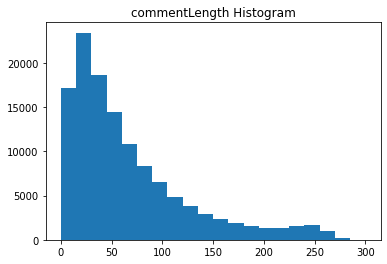

In [28]:
df['commentLength'] = df['commentBody'].apply(lambda x: len(x.split()))

if print_detail:
    display(df[['commentLength', 'commentBody']])

quick_look(df, 'commentLength', (0, 300), 20)

recommendations description: 


count    123692.000000
mean         19.421620
std          99.624274
min           0.000000
25%           1.000000
50%           4.000000
75%          11.000000
max        8713.000000
Name: recommendations, dtype: float64

0       19672
1       15767
2       12280
3        9728
4        7863
        ...  
2144        1
481         1
673         1
801         1
2783        1
Name: recommendations, Length: 955, dtype: int64

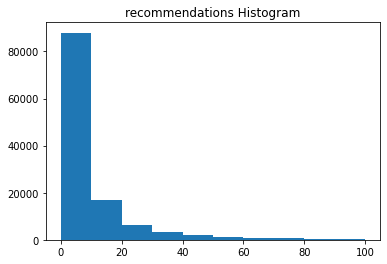

In [29]:
quick_look(df, 'recommendations', (0, 100))

In [30]:
#feature engineer recommendations into highly recommended
recommendations_threshold = df['recommendations'].quantile(0.9)
df['highly_recommended'] = df['recommendations'].apply(lambda x: True if x > recommendations_threshold else False)
df['recommended'] = df['recommendations'].apply(lambda x: True if x > 0 else False)
if print_detail:
    display(df['recommended'].value_counts())
    display(df['highly_recommended'].value_counts())

True     104020
False     19672
Name: recommended, dtype: int64

False    111710
True      11982
Name: highly_recommended, dtype: int64

replyCount description: 


count    123692.000000
mean          0.420270
std           2.955607
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         668.000000
Name: replyCount, dtype: float64

0      100609
1       13339
2        4596
3        2060
4        1040
5         643
6         372
7         243
8         183
9         125
10         98
11         78
12         52
13         43
14         28
15         26
17         22
16         13
18         13
22         10
21         10
23         10
20          9
19          7
25          6
24          5
29          5
30          5
36          4
28          3
31          3
26          3
32          2
54          2
45          2
37          2
35          2
55          2
33          1
208         1
89          1
52          1
130         1
113         1
46          1
69          1
42          1
105         1
41          1
40          1
39          1
38          1
668         1
530         1
61          1
Name: replyCount, dtype: int64

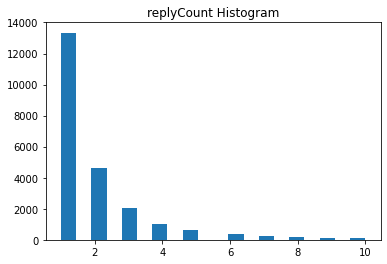

In [31]:
#reply count
quick_look(df, 'replyCount', (1, 10), 20)

In [32]:
#feature engineering reply count into categorical

df['replied_to'] = df['replyCount'].apply(lambda x: True if x > 0 else False)
df['highly_replied_to'] = df['replyCount'].apply(lambda x: True if x > 5 else False)

if print_detail:
    display(df['replied_to'].value_counts())
    display(df['highly_replied_to'].value_counts())

False    100609
True      23083
Name: replied_to, dtype: int64

False    122287
True       1405
Name: highly_replied_to, dtype: int64

In [33]:
df.loc[df['replyCount'] < 0]

,articleID,articleWordCount_x,commentBody,commentID,commentType,depth,editorsSelection,inReplyTo,newDesk_x,recommendations,replyCount,sectionName_x,timespeople,trusted,typeOfMaterial_x,documentType,headline,pubDate,article_comment_total,article_rec_total,article_reply_total,highly_commented,high_total_recommendations,high_total_reply,commentLength,highly_recommended,recommended,replied_to,highly_replied_to


depth description: 


count    123692.000000
mean          1.323877
std           0.503636
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: depth, dtype: float64

1.0    85768
2.0    35794
3.0     2123
4.0        7
Name: depth, dtype: int64

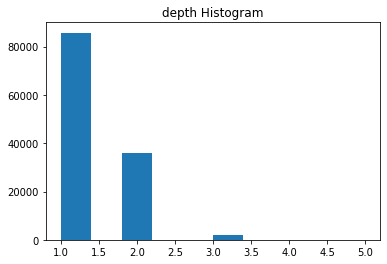

In [34]:
#depth
quick_look(df, 'depth', (1, 5))

editorsSelection description: 


count     123692
unique         2
top        False
freq      121825
Name: editorsSelection, dtype: object

False    121825
True       1867
Name: editorsSelection, dtype: int64

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



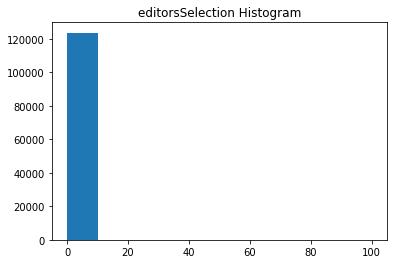

In [35]:
#editor selected
quick_look(df, 'editorsSelection', (0, 100))

timespeople description: 


count    123692.000000
mean          0.915726
std           0.277799
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: timespeople, dtype: float64

1    113268
0     10424
Name: timespeople, dtype: int64

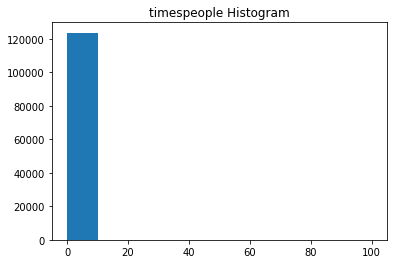

In [36]:
#timespeople
quick_look(df, 'timespeople', (0, 100))

trusted description: 


count    123692.000000
mean          0.033082
std           0.178852
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: trusted, dtype: float64

0    119600
1      4092
Name: trusted, dtype: int64

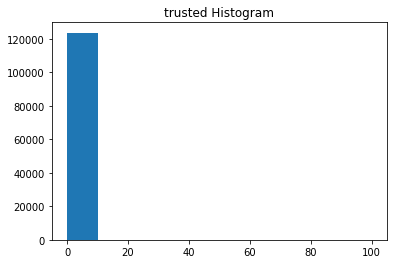

In [37]:
#trusted
quick_look(df, 'trusted', (0, 100))

### Feature Engineering Abuse Flag

In [38]:
# using this function to detect if we have any abusive comments

# def get_top_hs_class(sonar_obj, comment):
#     '''accepts a HateSonar Sonar object and a string comment (unprocessed) and returns the class with 
#     the highest confidence score.
#     Class options are: hate speech, offensive language, neither'''
#     results = sonar_obj.ping(text=comment)

#     # hs_conf = results['classes']['class_name' == 'hate_speech']['confidence']
#     # off_conf = results['classes']['class_name' == 'offensive_language']['confidence']
#     # none_conf = results['classes']['class_name' == 'neither']['confidence']

#     return results['top_class']

In [39]:
# sonar = Sonar()
# df['hateSonar_result'] = df['commentBody'].apply(lambda x: get_top_hs_class(sonar, x))

In [40]:
# pd.set_option('display.max_colwidth', 0)

# # display(df['hateSonar_result'].value_counts())

# # display(df['commentBody'].loc[df['hateSonar_result'] == 'hate_speech'])
# # display(df['commentBody'].loc[df['hateSonar_result'] == 'offensive_language'])

In [41]:
# # using this function to detect if we have any abusive comments

# def refine_top_hs_class(sonar_obj, comment):
#     '''accepts a HateSonar Sonar object and a string comment (unprocessed) and runs the hateSonar program.
#     If the comment is more likely than not to be either hate speech or offensive language, the program will 
#     revert the flag to neither (this is due to the high rate of false identifications)
#     Class options are: hate speech, offensive language, neither'''
#     #run hateSonar
#     results = sonar_obj.ping(text=comment)
    
#     #initially save top result as the label
#     label = results['top_class']

#     #if the initial label is hate speech or offensive language
#     if label != 'neither' and results['classes']['class_name' == 'neither']['confidence'] > 0.33:
#         label = 'neither'
        
#     if label == 'offensive_speech' and results['classes']['class_name' == 'hate_speech']['confidence'] > 0.2:
#         label = 'hate_speech'
        
#     return label

In [42]:
# df['hateSonar_refined'] = df['commentBody'].apply(lambda x: refine_top_hs_class(sonar, x))

In [43]:
# df['hateSonar_refined'].value_counts()

In [44]:
# # using this function to detect if we have any abusive comments

# def bool_top_hs_class(sonar_obj, comment):
#     '''accepts a HateSonar Sonar object and a string comment (unprocessed) and runs the hateSonar program.
#     If the comment is more likely than not to be either hate speech or offensive language, the program will 
#     Class options are: hate speech, offensive language, neither'''
    
#     #likelihood that speech is NOT hate speech must be lower than this value to be flagged
#     threshold = 0.03
    
#     #run hateSonar
#     results = sonar_obj.ping(text=comment)

#     #initially save top result as the label
#     label = results['top_class']

#     #if the initial label is hate speech or offensive language
#     if label == 'neither':
#         label = False
#     elif results['classes']['class_name' == 'neither']['confidence'] > threshold:
#         label = False
#     else:
#         label = True
        
#     return label

In [45]:
# df['hateSonar_abuse_flag'] = df['commentBody'].apply(lambda x: bool_top_hs_class(sonar, x))

In [46]:
# df['hateSonar_abuse_flag'].value_counts()

In [47]:
# df['commentBody'].loc[df['hateSonar_abuse_flag'] == True]

In [48]:
# df_sections = df.groupby(by='newDesk_x').sum()
# df_sections['hateSonar_abuse_flag']

In [49]:
# df.columns

Limitations: hate sonar detects problematic speech where there isn't any. It flags good-faith discussions of race, faith, sex/gender, suicide, and other topics sensitive topics. It also (understandably) struggles with quotes and sarcasm. 
It could also be missing problematic speech.
An interesting takeaway from this is that context is incredibly important for training hate speech detection tools. Hate speech in the comments of New York Times articles is likely to look very different from objectionable speech on Twitter at large, for example. 

## Text Preprocessing

In [50]:
nltk.download('stopwords')
nltk.download('wordnet')
#create stopwords set for computational efficiency
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [51]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [52]:
#test run for processing a single string - want to functionalize
#integers = []

def lower_and_sw_filter(comment_str):
    ''' this function returns a string with all the characters converted to lowercase
    and all stopwords and punctuation removed'''
    
    #strip html tags
    comment_str = strip_tags(comment_str)
    
    #lowercase
    comment_str = comment_str.lower()

    #tokenize
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

    comment_str = tokenizer.tokenize(comment_str)

    #stopwords

    filtered = list(filter(lambda x: x.lower() not in stopwords_set, comment_str))

    #lemmatize

    lemmatizer = WordNetLemmatizer()
    lemma = []
    for word in filtered:
#         #print(word)
#         if word.isdigit():
#             int_list.append(word)
        
        lemmatized_word = lemmatizer.lemmatize(word)
        lemma.append(lemmatized_word)
    
    lemma = ' '.join(lemma)
    
    return lemma

In [53]:
df['processed_comment'] = df['commentBody'].apply(lambda x: lower_and_sw_filter(x))
df.drop('commentBody', axis=1, inplace=True)
df.columns

Index(['articleID', 'articleWordCount_x', 'commentID', 'commentType', 'depth',
       'editorsSelection', 'inReplyTo', 'newDesk_x', 'recommendations',
       'replyCount', 'sectionName_x', 'timespeople', 'trusted',
       'typeOfMaterial_x', 'documentType', 'headline', 'pubDate',
       'article_comment_total', 'article_rec_total', 'article_reply_total',
       'highly_commented', 'high_total_recommendations', 'high_total_reply',
       'commentLength', 'highly_recommended', 'recommended', 'replied_to',
       'highly_replied_to', 'processed_comment'],
      dtype='object')

## Modeling 

Aside, data size issue

### Additional text preprocessing for modeling

Remove extra features

In [54]:
display(df.columns)

keep = ['recommendations',
        'highly_recommended', 
        'replyCount',
        'replied_to', 
        'editorsSelection', 
        'processed_comment']

df = reverse_drop(df, keep)
df.columns

Index(['articleID', 'articleWordCount_x', 'commentID', 'commentType', 'depth',
       'editorsSelection', 'inReplyTo', 'newDesk_x', 'recommendations',
       'replyCount', 'sectionName_x', 'timespeople', 'trusted',
       'typeOfMaterial_x', 'documentType', 'headline', 'pubDate',
       'article_comment_total', 'article_rec_total', 'article_reply_total',
       'highly_commented', 'high_total_recommendations', 'high_total_reply',
       'commentLength', 'highly_recommended', 'recommended', 'replied_to',
       'highly_replied_to', 'processed_comment'],
      dtype='object')

Index(['editorsSelection', 'recommendations', 'replyCount',
       'highly_recommended', 'replied_to', 'processed_comment'],
      dtype='object')

Predicting Recommendations

test-train split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('highly_recommended', axis=1), 
                                                    df['highly_recommended'], 
                                                    random_state=714)

TF-IDF

In [56]:
def tfidfify(train_text, test_text, tfidf=None):
    if not tfidf:
        tfidf = TfidfVectorizer(stop_words='english', dtype=np.float32, max_features = 10000)
    tfidf.fit(train_text)
    train_processed = tfidf.transform(train_text)
    
    test_processed = tfidf.transform(test_text)

    columns = tfidf.get_feature_names()
    return (
        pd.DataFrame(train_processed.toarray()),
        pd.DataFrame(test_processed.toarray()),
        columns
    )

In [57]:
vect = TfidfVectorizer(stop_words='english', dtype=np.float32, max_features = 30000)
train_processed, test_processed, feat_names = tfidfify(X_train['processed_comment'], X_test['processed_comment'], vect)

print('Training Data shape:')
display(train_processed.shape)
print('Testing Data shape:')
display(test_processed.shape)

Training Data shape:


(92769, 30000)

Testing Data shape:


(30923, 30000)

In [59]:
text_processing = Pipeline([
    ('vect', CountVectorizer(max_features=30000)),
    ('tfidf', TfidfTransformer())
])

In [60]:
text_processing.fit(X_train['processed_comment'])

processed_train = text_processing.transform(X_train['processed_comment'])
processed_test = text_processing.transform(X_test['processed_comment'])

print('Training Data shape:')
display(processed_train.shape)
print('Testing Data shape:')
display(processed_test.shape)

Training Data shape:


(92769, 30000)

Testing Data shape:


(30923, 30000)

In [61]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components = 10000)
# pca.fit_transform(train_processed)
# print(np.sum(pca.explained_variance_ratio_))

In [62]:
nb_model = LogisticRegression()

nb_model.fit(processed_train.toarray(), y_train.values.ravel())

y_hat_test = nb_model.predict(processed_test)
print(classification_report(y_test, y_hat_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



NameError: ignored

## Evaluation

## Conclusions